**Tutorial 5 - Measuring a Spectral Line by Bayesian Parameter Estimation**

In this tutorial you will measure the strength and width of a spectral line 
using a Bayesian method.


1) Read in the data from the file tut_05_data.csv.  There are three 
columns: wavelength, flux and sigma.  Sigma is the known standard deviation 
of the flux in each pixel.  Plot the spectrum using matplotlib.pyplot.errorbar().

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pa

df = pa.read_csv('tut_05_data.csv')
plt.errorbar(df['wavelength'],df['flux'], yerr=df['sigma'],fmt='o')
plt.xlabel(r'$\lambda$')
plt.ylabel('flux')
plt.show()

<Figure size 640x480 with 1 Axes>

2) First we need to subtract off the continuum. We know that there is a line centered around $\lambda \simeq 23$.  Take the part of the spectrum with $\lambda > 45$ which should just be background.  Assuming the noise is Gaussian and uncorrelated.   Using a uniform prior on the background.

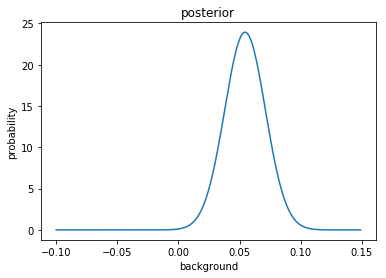

Posterior at edges of parameter space:  5.145873718776107e-18 2.52702008593455e-06
Optimization terminated successfully.
         Current function value: 22.314737
         Iterations: 16
         Function evaluations: 32
The maximum likelihood background is : [0.0545]
The average of posterior  : 0.05453108678141714
The variance of posterior  : 0.016666664987686954


In [2]:

import scipy.optimize as opt

## filter out the background dominated region of the spectrum
f = df['flux'][ df['wavelength'] > 45 ]
l = df['wavelength'][ df['wavelength'] > 45 ]
s = df['sigma'][ df['wavelength'] > 45 ]

#plt.plot(l,f)
#plt.show()

## make a log-likelihood function assuming the noise Gaussian and 
## the pixels are independent
def loglike(b):
    return -0.5*np.sum( ( (f - b)/s )**2  )   ## this is chi^2

## Make an array of possible background values.
## To find the right range it is sometimes useful to 
## plot the log-likelihood over different ranges until 
## you find the maximum.
db = 0.001 ## resolution in background
background = np.arange(-0.1,0.15,db)

## calculate the likelihood at each of these background values
likelihood = np.empty(len(background))
for i,b in enumerate(background) :
    likelihood[i] = np.exp( loglike(b) )

## normalize to get the posterior
## You should look at the plot and make sure that
## the sum is a good approximation of the integral.
posterior = likelihood/np.sum(likelihood)/db
    
## plot posterior for background
plt.plot(background,posterior)
plt.xlabel('background')
plt.ylabel('probability')
plt.title('posterior')

plt.show()

print ('Posterior at edges of parameter space: ',posterior[0],posterior[-1])

## find maximum of posterior and the variance
bmax = opt.fmin(lambda x: -loglike(x),0)
print ('The maximum likelihood background is :',bmax)
bave = np.sum(posterior*background)*db
variance = np.sum(posterior*(background-bave)**2)*db
print ('The average of posterior  :',bave)
print ('The variance of posterior  :',np.sqrt(variance))


3) Now lets fit the line.  Assume the line has the profile

$ f(\lambda) = A \exp\left[- \left( \frac{(\lambda - \lambda_o)}{\Delta\lambda }\right)^2 \right] $

We want to find the parameters $A$, $\lambda_o$, $\Delta\lambda$ and the background.  

Write a function for the line profile.  

Write a function that returns the log-likelihood for the data with this model. 

Find the maximum likelihood values for the parameters using the whole data set.  Use the library function scipy.optimize.minimize() to do this.  Read the documentation for this function before starting.  You will need to make a guess to start the minimization.  Make these guesses from the plot of the data.

Draw the best fit model over the data.

In [3]:
#def loglike(b,lo,dl,A):
f = df['flux']
l = df['wavelength']
s = df['sigma']


def fl(ll,lo,dl,A):
    return A*np.exp(-((ll-lo)/dl)**2)

def loglikenew(p):
    return 0.5*np.sum( ((f- fl(l,p[1],p[2],p[3]) -p[0]) /s)**2 )

guess=np.array([0,23,1,1])

max1=opt.minimize(loglikenew,guess)
max=max1['x']
print(max)
print('A = ' + str(max[3]))
print('lo = '+str(max[1]))
print('dl = ' + str(max[2]))
print('b = '+str(max[0]))


[ 0.0286165  24.11716855  2.61398135  1.02866769]
A = 1.0286676879734284
lo = 24.11716855226407
dl = 2.6139813459327184
b = 0.028616503769336814


4) Set all the parameters to their maximum likelihood values except the line strength $A$.  Make a plot of the posterior for $A$ near its maximum likelihood value with uniform and Jaffreys priors on $A$.

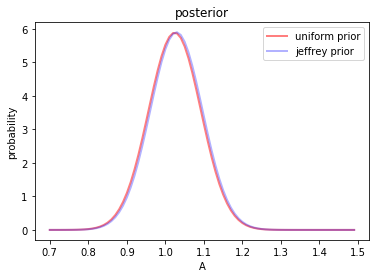

mean of A (uniform)= 1.028667825411
mean of A (jeffrey)= 1.0241775555327548


In [4]:

def loglikeA(a):
    return loglikenew(np.array([max[0],max[1],max[2],a]))

da = 0.01
strength= np.arange(0.7,1.5,da)

likelihood = np.empty(len(strength))
for i,b in enumerate(strength) :
    likelihood[i] = np.exp( -loglikeA(b) )
posterior = likelihood/np.sum(likelihood)/da

likelihoodj = np.empty(len(strength))
for i,b in enumerate(strength) :
    likelihoodj[i] = np.exp( -loglikeA(b) )/strength[i]
posteriorj = likelihoodj/np.sum(likelihoodj)/da


plt.plot(strength,posteriorj,color='red',label='uniform prior',alpha=0.5,linewidth=2)
plt.plot(strength,posterior,color='blue',label='jeffrey prior',alpha=0.3,linewidth=2)
plt.xlabel('A')
plt.ylabel('probability')
plt.title('posterior')
plt.legend(loc='upper right')
plt.show()

mean = np.sum(posterior*strength)*da
meanj = np.sum(posteriorj*strength)*da
print('mean of A (uniform)= '+str(mean))
print('mean of A (jeffrey)= '+str(meanj))



5) Make a 2D map of the posterior as a function of $A$ and $\Delta \lambda$ at the maximum likelihood values of the other parameters.  Do this by making a grid of $A$ and $\Delta \lambda$ values and using matplotlib.pyplot.contour().  Put the proper labels on the axes.

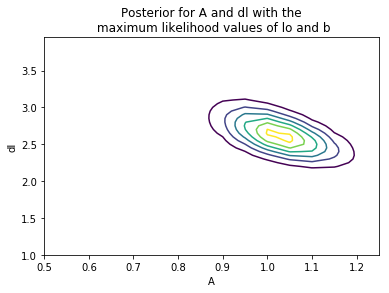

In [5]:
da = 0.05
x= np.arange(0.5,1.3,da)
ddl=0.05
y=np.arange(1,4,ddl)
X,Y = np.meshgrid(x,y)
likelihood2d=np.empty([len(y),len(x)])
post2d=np.empty([len(y),len(x)])
for i in range(len(x)):
    for j in range(len(y)):
        likelihood2d[j,i]=np.exp(-loglikenew(np.array([max[0],max[1],y[j],x[i]])))
post2d = likelihood2d/ np.sum(likelihood2d)/da/ddl
plt.title('Posterior for A and dl with the\n maximum likelihood values of lo and b')
plt.contour(X,Y,post2d)
plt.xlabel('A')
plt.ylabel('dl')
plt.show()

6) Write a function that takes values for $A$ and $\Delta \lambda$ and returns the 
posterior marginalizes over $\lambda_o$.  Use scipy.integrate.quad() to do the 
integration.  You will need to make a new "posterior" function with the correct 
order of input parameters to use this function.  Use the maximum likelihood value for the background from part 2).  You might want to reduce the resolution of the grid to reduce the run time.

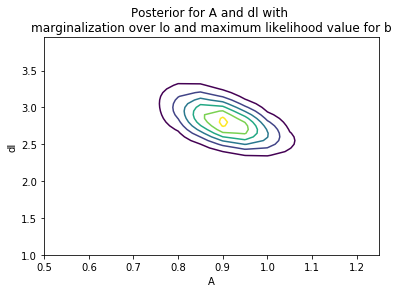

In [6]:
import scipy.integrate as inte
def llike(lo,dl,a):
    return loglikenew(np.array([bmax,lo,dl,a]))

def like(lo,dl,a):
    return np.exp(-llike(lo,dl,a))

def post(dl,a):
    return inte.quad(like,0,100,args=(dl,a))[0]

#for 2D posterior normalization but it's useless since 
#i have to renormalize the 1D posteriors later
#and even without normalization the contour plot looks the same
def norm(a):
    return inte.quad(post,0,6,args=a)[0]
norma=inte.quad(norm,0,6)[0]

def postnorm(dl,a):
    return post(dl,a)/norma


post2dm=np.empty([len(y),len(x)])
for i in range(len(x)):
    for j in range(len(y)):
        post2dm[j,i]=postnorm(y[j],x[i])
plt.title('Posterior for A and dl with \nmarginalization over lo and maximum likelihood value for b')
plt.xlabel('A')
plt.ylabel('dl')
plt.contour(X,Y,post2dm)
plt.show()


7) Sum the 2D array from 6) to find the 1D marginalized posteriors for both ΔλΔλ and AA.

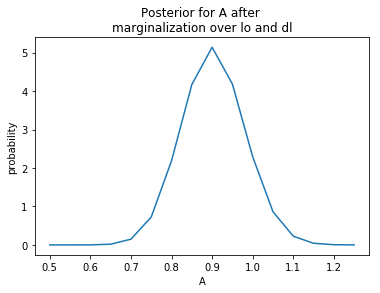

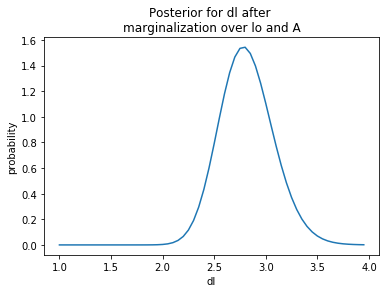

In [7]:
def postA(a):
    return inte.quad(post,0,6,args=a)[0]
posta=np.empty(len(x))
for i in range(len(x)):
    posta[i]=postA(x[i])
posta=posta/np.sum(posta)/da
plt.plot(x,posta)
plt.title('Posterior for A after \nmarginalization over lo and dl')
plt.xlabel('A')
plt.ylabel('probability')
plt.show()

def postrev(a,dl):
    return post(dl,a)
def postdl(dl):
    return inte.quad(postrev,0,2,args=dl)[0]
postdll=np.empty(len(y))
for i in range(len(y)):
    postdll[i]=postdl(y[i])
postdll=postdll/np.sum(postdll)/ddl
plt.plot(y,postdll)
plt.title('Posterior for dl after \nmarginalization over lo and A')
plt.xlabel('dl')
plt.ylabel('probability')
plt.show()

8) Do the same as 6) and 7) but for $A$ and $\lambda_o$ and marginalized over $\Delta\lambda$.

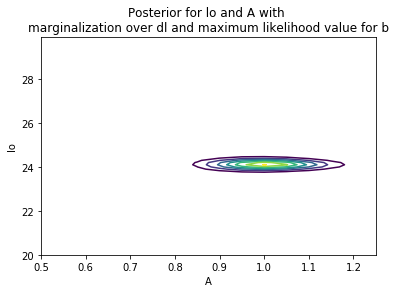

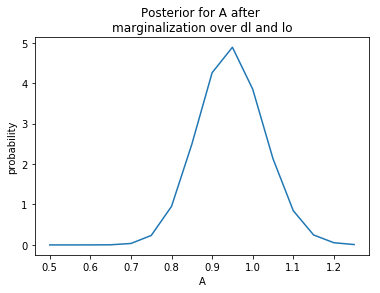

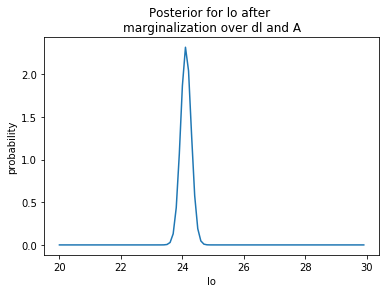

In [8]:
def likerev(dl,lo,a):
    return like(lo,dl,a)

def postloa(lo,a):
    return inte.quad(likerev,0,5,args=(lo,a))[0]

dl=0.1
z=np.arange(20,30,dl)
X,Z=np.meshgrid(x,z)
postloam=np.empty([len(z),len(x)])
for i in range(len(x)):
    for j in range(len(z)):
        postloam[j,i]=postloa(z[j],x[i])
plt.title('Posterior for lo and A with \nmarginalization over dl and maximum likelihood value for b')
plt.xlabel('A')
plt.ylabel('lo')
plt.contour(X,Z,postloam)
plt.show()

def postA1(a):
    return inte.quad(postloa,0,60,args=a)[0]
posta1=np.empty(len(x))
for i in range(len(x)):
    posta1[i]=postA1(x[i])
posta1=posta1/np.sum(posta1)/da
plt.plot(x,posta1)
plt.title('Posterior for A after \nmarginalization over dl and lo')
plt.xlabel('A')
plt.ylabel('probability')
plt.show()

def postloarev(a,lo):
    return postloa(lo,a)
def postlo(lo):
    return inte.quad(postloarev,0,6,args=lo)[0]
postLo=np.empty(len(z))
for i in range(len(z)):
    postLo[i]=postlo(z[i])
postLo=postLo/np.sum(postLo)/dl
plt.plot(z,postLo)
plt.title('Posterior for lo after \nmarginalization over dl and A')
plt.xlabel('lo')
plt.ylabel('probability')
plt.show()

9) Do the same as 6) and 7) but for $\Delta\lambda$ and $\lambda_o$ and marginalized over $A$.

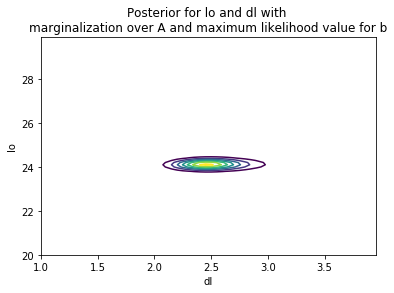

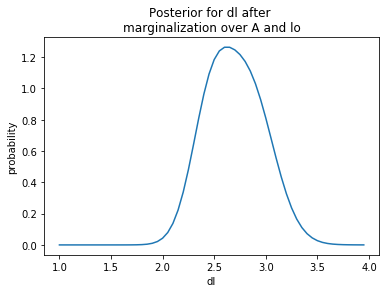

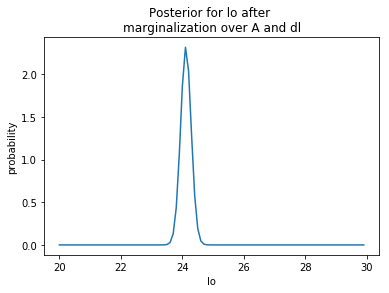

In [11]:
def likerev1(a,lo,dl):
    return like(lo,dl,a)

def postldl(lo,dl):
    return inte.quad(likerev1,0,6,args=(lo,dl))[0]
Y,Z=np.meshgrid(y,z)
postldlm=np.empty([len(z),len(y)])
for i in range(len(y)):
    for j in range(len(z)):
        postldlm[j,i]=postldl(z[j],y[i])
plt.title('Posterior for lo and dl with \nmarginalization over A and maximum likelihood value for b')
plt.xlabel('dl')
plt.ylabel('lo')
plt.contour(Y,Z,postldlm)
plt.show()

def postdl_(dl):
    return inte.quad(postldl,0,60,args=dl)[0]
postdl1=np.empty(len(y))
for i in range(len(y)):
    postdl1[i]=postdl_(y[i])
postdl1=postdl1/np.sum(postdl1)/ddl
plt.plot(y,postdl1)
plt.title('Posterior for dl after \nmarginalization over A and lo')
plt.xlabel('dl')
plt.ylabel('probability')
plt.show()

def postldlrev(dl,lo):
    return postloa(lo,dl)
def postlo_(lo):
    return inte.quad(postldlrev,0,6,args=lo)[0]
postlo1=np.empty(len(z))
for i in range(len(z)):
    postlo1[i]=postlo_(z[i])
postlo1=postlo1/np.sum(postlo1)/dl
plt.plot(z,postlo1)
plt.title('Posterior for lo after \nmarginalization over A and dl')
plt.xlabel('lo')
plt.ylabel('probability')
plt.show()

10) Give the maximum likelihood estimate of each of the three parameters and 
their marginalized standard deviation. 

In [10]:
print('A: RESULTS OBTAINED MARGINALIZING OVER lo AND THEN OVER dl')
amax = opt.fmin(lambda x: -postA(x),1)
print('maximum likelihood value of A:' +str(amax))
amean = np.sum(posta*x)*da
avariance = np.sum(posta*(x-amean)**2)*da
print ('average of A:',amean)
print ('variance of A:',np.sqrt(avariance))
print('A: RESULTS OBTAINED MARGINALIZING OVER dl AND THEN OVER lo')
a1max= opt.fmin(lambda x: -postA1(x),1)
print('maximum likelihood value of A:' +str(a1max))
a1mean = np.sum(posta1*x)*da
a1variance = np.sum(posta1*(x-amean)**2)*da
print ('average of A:',a1mean)
print ('variance of A:',np.sqrt(a1variance))

print('')
print('dl: RESULTS OBTAINED MARGINALIZING OVER lo AND THEN OVER A')
dlmax= opt.fmin(lambda x: -postdl(x),1)
print('maximum likelihood value of dl:' +str(dlmax))
dlmean = np.sum(postdll*y)*ddl
dlvariance = np.sum(postdll*(y-dlmean)**2)*ddl
print ('average of dl:',dlmean)
print ('variance of dl:',np.sqrt(dlvariance))
print('dl: RESULTS OBTAINED MARGINALIZING OVER A AND THEN OVER lo')
dl1max= opt.fmin(lambda x: -postdl_(x),1)
print('maximum likelihood value of dl:' +str(dl1max))
dl1mean = np.sum(postdl1*y)*ddl
dl1variance = np.sum(postdl1*(y-dl1mean)**2)*ddl
print ('average of dl:',dl1mean)
print ('variance of dl:',np.sqrt(dl1variance))

print('')
print('lo: RESULTS OBTAINED MARGINALIZING OVER dl AND THEN OVER A')
lomax= opt.fmin(lambda x: -postlo(x),23)
print('maximum likelihood value of lo:' +str(lomax))
lomean = np.sum(postLo*z)*dl
lovariance = np.sum(postLo*(z-lomean)**2)*dl
print ('average of lo:',lomean)
print ('variance of lo:',np.sqrt(lovariance))
print('lo: RESULTS OBTAINED MARGINALIZING OVER A AND THEN OVER dl')
lo1max= opt.fmin(lambda x: -postlo_(x),23)
print('maximum likelihood value of lo:' +str(lo1max))
lo1mean = np.sum(postlo1*z)*dl
lo1variance = np.sum(postlo1*(z-lo1mean)**2)*dl
print ('average of lo:',lo1mean)
print ('variance of lo:',np.sqrt(lo1variance))

A: RESULTS OBTAINED MARGINALIZING OVER lo AND THEN OVER dl
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 12
         Function evaluations: 24
maximum likelihood value of A:[0.89980469]
average of A: 0.9027206189330139
variance of A: 0.07771624437282283
A: RESULTS OBTAINED MARGINALIZING OVER dl AND THEN OVER lo
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 11
         Function evaluations: 22
maximum likelihood value of A:[0.94287109]
average of A: 0.9468352148861545
variance of A: 0.09264521136008781

dl: RESULTS OBTAINED MARGINALIZING OVER lo AND THEN OVER A
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 18
         Function evaluations: 36
maximum likelihood value of dl:[2.78232422]
average of dl: 2.8162045557528645
variance of dl: 0.261284216466845
dl: RESULTS OBTAINED MARGINALIZING OVER A AND THEN OVER lo
Optimization